# Create a mask for the region of interest and make a plot of the region 

### Time taken: ~ 2 mins

#### This notebook includes the creation of Fig 1
------

In [1]:
import numpy as np
import xarray as xr

import regionmask

import myfuncs as my

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings("ignore")

In [2]:
cartopy.config['pre_existing_data_dir'] = '/g/data/v14/ds0092/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/v14/ds0092/data/cartopy-data'

--------
## Load burned area data

In [3]:
def preprocess(ds):
    for drop in ['crs','time_bounds','lat_bounds','lon_bounds','number_of_patches']:
        if drop in ds:
            ds = ds.drop(drop)
    return ds.assign_coords({'vegetation_class': vegetation_class})

In [4]:
data_path = '/g/data/xv83'
vegetation_class = xr.open_dataset(
    f'{data_path}/observations/CCI_fire/20200101-C3S-L4_FIRE-BA-OLCI-fv1.0.nc')['vegetation_class']
CCI_fire = xr.open_mfdataset(
    f'{data_path}/observations/CCI_fire/*.nc', preprocess=preprocess)
CCI_fire = CCI_fire.assign_coords({'lon': (CCI_fire['lon'] + 360)  % 360}).sortby('lon')

burned_area = CCI_fire['burned_area_in_vegetation_class'].sel(
    vegetation_class=50).rename(r'Burned forest area [m$^2$]').compute()

cafe_grid = my.open_zarr(
    '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20201101/atmos_isobaric_daily.zarr.zip',
    preprocess=my.truncate_latitudes)[['lat','lon']]

--------
## Save region mask

In [5]:
def get_region_mask(area, grid, threshold):
    """ Get region mask based on burned area threshold """
    def aggregate_grid(ds, lat_des, lon_des, lat_name='lat', lon_name='lon'):
        def _get_bin_edges(bins):
            dbin = np.diff(bins)/2
            bin_edges = np.concatenate(([bins[0]-dbin[0]], 
                                         bins[:-1]+dbin, 
                                         [bins[-1]+dbin[-1]]))
            return bin_edges

        lat_edges = _get_bin_edges(lat_des)
        lon_edges = _get_bin_edges(lon_des)
        lat_in = np.where((lat_edges < max(ds[lat_name].values)) & (lat_edges > min(ds[lat_name].values)))[0]
        lon_in = np.where((lon_edges < max(ds[lon_name].values)) & (lon_edges > min(ds[lon_name].values)))[0]
        lat_edges = lat_edges[lat_in]
        lat_des = lat_des[lat_in[:-1]]
        lon_edges = lon_edges[lon_in]
        lon_des = lon_des[lon_in[:-1]]

        ds_cpy = ds.copy()
        ds_sum = ds_cpy.groupby_bins(lon_name, lon_edges, labels=lon_des).sum(lon_name, skipna=False) \
                       .groupby_bins(lat_name, lat_edges, labels=lat_des).sum(lat_name, skipna=False)

        return (ds_sum).rename({lon_name+'_bins': lon_name,
                                lat_name+'_bins': lat_name})
    
    area_agg = aggregate_grid(area, grid['lat'].values, grid['lon'].values)
    return xr.where(area_agg / grid.area > (threshold/100), 1, 0)

In [6]:
burned_area_period = burned_area.sel(time=slice('2019-10','2020-02')).sum('time')
area_threshold = 10

mask = get_region_mask(burned_area_period, cafe_grid, area_threshold).drop(
    ['vegetation_class', 'area', 'zsurf']).rename('region_mask')
mask.to_netcdf(f'./data/region_mask.ONDJF.{area_threshold}.nc')

## Plot Fig 1 for paper

In [45]:
def plot_Fig_1(area, mask, cmap, figsize=(3.5,5.5)):
    def plot_mask(mask):
        def _plot_patch(lw, col):
            for j, i in np.column_stack(np.where(mask)):
                ax.add_patch(
                    mpatches.Rectangle((mask.lon[i]-180-dlon/2, 
                                        mask.lat[j]-dlat/2), 
                                       dlon, dlat,    
                                       fill=False, 
                                       linewidth=lw, 
                                       snap=False, 
                                       color=col, 
                                       zorder=3))
        dlon = np.diff(mask.lon)[0]
        dlat = np.diff(mask.lat)[0]
        _plot_patch(1.5, 'w')
        _plot_patch(0.75, 'k')
    
    Earth_filename = '/g/data/v14/ds0092/data/natural-earth-quick-start/50m_raster/NE1_50M_SR_W/NE1_50M_SR_W.tif'
    img = plt.imread(Earth_filename)
    
    fig = plt.figure(figsize=figsize, edgecolor='k')
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(180))
    region = [135, 154, -44, -26]
    ax.set_extent(region, ccrs.PlateCarree())
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    for country in countries:
        if country.attributes['ADMIN'] == 'Australia':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=(0.96,0.96,0.96))
    ax.add_feature(cartopy.feature.RIVERS, linewidth=0.75)
    
    p = area.where(area > 0).plot(ax=ax, transform=ccrs.PlateCarree(),
                                  cmap=cmap, 
                                  cbar_kwargs={'pad': 0.07, 'aspect': 30, 'orientation': 'horizontal', 
                                               'ticks': np.arange(0, 6.75e8, 0.75e8)}, zorder=2)
    
    p.axes.coastlines(color='w', linewidth=1.5)
    p.axes.coastlines(color=[0.2,0.2,0.2], linewidth=0.75)
    ax.set_xticks(np.arange(region[0],region[1]+1,5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(region[2],region[3]+1,5), crs=ccrs.PlateCarree())
    ax.tick_params(axis="y",direction='in')
    ax.tick_params(axis="x",direction='in')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    gl_lines = ax.gridlines(crs=ccrs.PlateCarree(),
                            draw_labels=False,
                            linewidth=0, 
                            color='grey', 
                            alpha=0.3, 
                            linestyle='-',
                            xlocs=np.arange(region[0],region[1]+1,1),
                            ylocs=np.arange(region[2],region[3]+1,1))
    gl_labels = ax.gridlines(crs=ccrs.PlateCarree(),
                             draw_labels=True,
                             linewidth=0, 
                             color='grey', 
                             alpha=0.3, 
                             linestyle='-',
                            xlocs=np.arange(region[0],region[1]+1,5),
                            ylocs=np.arange(region[2],region[3]+1,5))
    gl_labels.xlabels_top = False
    gl_labels.ylabels_right=False
    gl_labels.xlabel_style = {'fontsize': rc_context['font.size'], 
                              'color': rc_context['text.color']}
    gl_labels.ylabel_style = {'fontsize': rc_context['font.size'], 
                              'color': rc_context['text.color']}
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plot_mask(mask)
    
    # Add inset
    ax = fig.add_axes([0.15,0.60,0.26,0.16], projection=ccrs.PlateCarree(180))
    extent=[111, 156, -46, -8]
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.imshow(img, origin='upper', transform=ccrs.PlateCarree())
    ax.coastlines(color='grey', linewidth=0.5)
    ax.plot([region[0], region[1], region[1], region[0], region[0]],
            [region[2], region[2], region[3], region[3], region[2]], 
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree())
    
    return fig

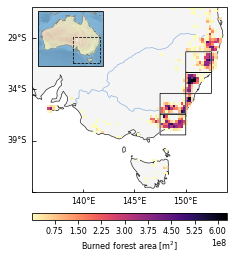

In [46]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize}

with plt.rc_context(rc_context):
    fig = plot_Fig_1(burned_area_period, mask, cmap='magma_r', figsize=(3.5,5.5))
    
fig.savefig(f'./figures/region.pdf', format='pdf', 
            bbox_inches='tight')

--------
## Save Australia mask

In [10]:
countries = regionmask.defined_regions.natural_earth.countries_110
AUS_index = regionmask.defined_regions.natural_earth.countries_110.map_keys("Australia")

### On CAFE grid

In [11]:
data_path = '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20201101'
cafe = my.open_zarr(
    f'{data_path}/atmos_isobaric_daily.zarr',
    preprocess=my.truncate_latitudes)[['lon','lat']]
mask = (countries.mask(cafe['lon'], cafe['lat']) == AUS_index).rename('australia_mask')
mask.to_netcdf(f'./data/Aus_mask.cafe_grid.nc')

### On JRA-55 grid

In [12]:
data_path = '/g/data/xv83/reanalyses/JRA55'
jra = my.open_zarr(
    f'{data_path}/surface_daily.zarr')[['g0_lon_2','g0_lat_1']]
mask = (countries.mask(jra['g0_lon_2'], jra['g0_lat_1']) == AUS_index).rename('australia_mask')
mask.to_netcdf(f'./data/Aus_mask.jra_grid.nc')

### On AWAP grid

In [13]:
data_path = '/g/data/xv83/observations/AWAP'
awap = my.open_zarr(
    f'{data_path}/rain_day_19000101-20210425.zarr')[['lon','lat']]
mask = (countries.mask(awap['lon'], awap['lat']) == AUS_index).rename('australia_mask')
mask.to_netcdf(f'./data/Aus_mask.awap_grid.nc')

--------
# End notebook